<font size="5">**Algorytmy danych geoprzestrzennych**</font><br>
<font size="4">Przetwarzanie danych rastrowych</font>

<font size="4">Krzysztof Dyba</font>

In [1]:
import os
from qgis.core import QgsRasterLayer

# wczytanie rastra
filepath = os.path.join("algorytmy-geoprzestrzenne", "dane", "DEM.tif")
raster = QgsRasterLayer(filepath, "DEM")
print(raster.isValid())

True


In [2]:
# wyświetlenie metadanych
print("Liczba kolumn (Szerokość):", raster.width())
print("Liczba wierszy (Wysokość):", raster.height())
print("Liczba komórek:", raster.height() * raster.height())
print("Liczba kanałów:", raster.bandCount())
print("Zakres:", raster.extent().toString(precision = 2))
print("CRS:", raster.crs().authid())

Liczba kolumn (Szerokość): 533
Liczba wierszy (Wysokość): 608
Liczba komórek: 369664
Liczba kanałów: 1
Zakres: 253698.33,353734.36 : 520058.23,657570.76
CRS: EPSG:2180


# Odczyt wartości

1. Dla punktu:
- jeśli mamy wiele punktów i kilka kanałów, to oczywiście trzeba zastosować pętlę
- układ współrzędnych rastra i punktów musi być jednakowy
- alternatywnie można użyć `identify()`
2. Dla bloku
3. Cały raster

In [3]:
from qgis.core import QgsPointXY

point = QgsPointXY(389900, 507600)
value = raster.dataProvider().sample(point, 1)
print(value)

# punkt jest poza zakresem rastra
point = QgsPointXY(0, 0)
value = raster.dataProvider().sample(point, 1)
print(value)

(141.6381072998047, True)
(nan, False)


In [4]:
from qgis.core import QgsRectangle

provider = raster.dataProvider()
rect = QgsRectangle(346950, 454028, 393355, 493871) # xmin, ymin, xmax, ymax

# określenie liczby kolumn i wierszy
width = int(rect.width() / raster.rasterUnitsPerPixelX())
height = int(rect.height() / raster.rasterUnitsPerPixelY())

# pobranie wartości pikseli dla prostokąta
block = provider.block(1, rect, width, height)
print(block.isValid())
print("Liczba komórek:", block.width() * block.height())

True
Liczba komórek: 7268


In [5]:
for x in range(0, 3): # block.width()
    for y in range(0, 3): # block.height()
        print(x, y, round(block.value(x, y), 2))

0 0 79.54
0 1 83.73
0 2 85.62
1 0 78.35
1 1 78.12
1 2 80.94
2 0 77.76
2 1 78.12
2 2 80.94


## Docinanie rastra

Wczytany blok w rzeczywistości jest niczym innym jak rastrem dociętym przez zakres przestrzenny. Wynik tej operacji możemy zapisać na dysku.

In [6]:
from qgis.core import QgsRasterFileWriter, QgsRasterPipe, QgsCoordinateTransformContext

pipe = QgsRasterPipe()
provider = raster.dataProvider()
pipe.set(provider.clone())

writer = QgsRasterFileWriter("DEM_crop.tif")
writer.setCreateOptions(["COMPRESS=LZW"])
writer.setOutputFormat('GTiff')

status = writer.writeRaster(
    pipe,
    width,
    height,
    rect,
    raster.crs(),
    QgsCoordinateTransformContext()
)

if status != 0:
    print("Błąd zapisu")
else: 
    print("OK")

OK


In [7]:
import numpy as np

extent = raster.extent()
cols = raster.width()
rows = raster.height()
block = provider.block(1, extent, cols, rows)
array = np.frombuffer(block.data(), dtype = np.float32)
array = array.reshape(rows, cols)
print(array.shape) # wiersze, kolumny
print(array[100:104, 100:104])

(608, 533)
[[ 99.89686  117.18553  122.53293  132.92046 ]
 [104.782074 121.91743  122.99693  122.71936 ]
 [122.32443  120.56837   98.11017  105.36948 ]
 [100.51226  113.48083  120.141685 105.36948 ]]


# Algebra rastrów

Klasa [QgsRasterCalculator](https://qgis.org/pyqgis/master/analysis/QgsRasterCalculator.html) umożliwia dostęp do [kalkulatora rastrów](https://docs.qgis.org/3.34/en/docs/user_manual/working_with_raster/raster_analysis.html) w QGIS. Dostępne są operatory matematyczne, trygonometryczne, porównania oraz logiczne (dzięki czemu możliwe jest zamaskowanie czy reklasyfikacja wartości).

- jeśli mamy kilka rastrów, to muszą mieć takie same zasięgi oraz rozdzielczość

- współczynnik przewyższenia żeby uwypuklić formy rzeźby terenu
- maskowanie (wyznaczenie dolin rzecznych)
- reklasyfikacja

In [8]:
from qgis.analysis import QgsRasterCalculator, QgsRasterCalculatorEntry

a = QgsRasterCalculatorEntry()
a.raster = raster
a.bandNumber = 1
a.ref = 'DEM@1'

calculator = QgsRasterCalculator(
    formulaString = "DEM@1 * 5",
    outputFile = "output.tif",
    outputFormat = "GTiff",
    outputExtent = raster.extent(),
    # outputCrs = raster.crs(),
    nOutputColumns = raster.width(),
    nOutputRows = raster.height(),
    rasterEntries = [a],
    transformContext = QgsCoordinateTransformContext()
)

calculator.processCalculation() ## dlaczego CRS nie przekazany?

0

In [10]:
test = QgsRasterLayer("output.tif", "test")
print(test.isValid())
print(test.crs())
#> <QgsCoordinateReferenceSystem: invalid>

True
<QgsCoordinateReferenceSystem: invalid>


```python
# maskowanie
formulaString = "('DEM@1' < 80) * 'DEM@1'"
```

```python
# reklasyfikacja
formulaString = "('DEM@1' < 94) * 1 + ('DEM@1' >= 94 AND 'DEM@1' <= 125) * 2 + ('DEM@1' > 125) * 3"
```

# Obliczenie histogramu

In [21]:
from qgis.core import QgsRasterHistogram

provider = raster.dataProvider()
bin_count = 100  # liczba przedziałów w histogramie

# oblicz histogram
histogram = provider.histogram(1, bin_count)
bins = range(0, histogram.binCount)
vals = histogram.histogramVector

# TODO:
# - biny powinny pokazywać wysokość terenu na osi X
# - czy da się zoptymalizować liczbę binów (QgsHistogram.optimalNumberBins())?

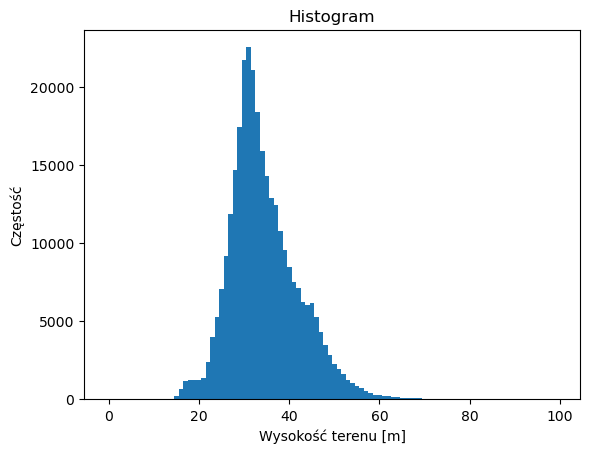

In [22]:
import matplotlib.pyplot as plt

plt.bar(bins, vals, width = 1)
plt.title("Histogram")
plt.xlabel("Bin") # powinno być: Wysokość terenu [m]
plt.ylabel("Częstość")
plt.show()

# Przepróbkowanie rastra

# Zadania:

10) Pobierz scenę satelitarną Landsata 8/9 z [EarthExplorer](https://earthexplorer.usgs.gov/), która zawiera kanał panchromatyczny (15 m; produkt L1C) oraz kanały niebieski, zielony i czerwony (30 m; produkt L2A), a następnie zwiększ rozdzielczość przestrzenną kompozycji RGB używając pansharpeningu. W najprostszym wariancie należy uśrednić wartości spektralne kanałów:

```
wynik = (kanał + kanał panchromatyczny) / 2
```

W zaawansowanym wariancie można zastosować inną wybraną technikę pansharpeningu, np. [Brovey'a](https://grass.osgeo.org/grass-stable/manuals/i.pansharpen.html#description). Dla uproszczenia przetwarzania obrazy należy dociąć do mniejszego zakresu przestrzennego. Wynik zapisz na dysku jako obraz składający się z trzech kanałów w formacie `.tif`.